# Install, import and loading dataset

In [1]:
#!pip3 install textstat
#!pip3 install -U pip setuptools wheel
#!pip3 install -U spacy
#!python3 -m spacy download en_core_web_sm
#!python3 -m spacy download en_core_web_lg
#!pip install langdetect -- this required too

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import spacy
nlp = spacy.load('en_core_web_lg')
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
nlp_sm = spacy.load('en_core_web_sm')
import textstat as ts
vocab = list(nlp_sm.vocab.strings)
import seaborn as sns
import gc
import re
from langdetect import detect
from langdetect import detect_langs

Read the csv as a dataframe using pandas

In [3]:
df = pd.read_csv('books_and_genres.csv', index_col=0)
df.head()

,title,text,genres
0,apocolocyntosis,"Produced by Ted Garvin, Ben Courtney and PG Di...","{'21st-century', 'history', 'roman', 'classics..."
1,the house on the borderland,"Produced by Suzanne Shell, Sjaani and PG Distr...","{'horror', 'mystery', 'classics', 'science-fic..."
2,the warriors,"Produced by Charles Aldarondo, Charlie Kirschn...","{'literary-fiction', 'history', 'biography', '..."
3,a voyage to the moon,"Produced by Christine De Ryck, Stig M. Valstad...","{'20th-century', 'science-fiction', 'speculati..."
4,la fiammetta,"Produced by Ted Garvin, Dave Morgan and PG Dis...","{'literary-fiction', 'history', 'feminism', 'c..."


# Preprocessing

## Reformatting dataset
* Drop any columns or values that is not required
* Note: spaCy can only allocate enough RAM for this many chars in a doc

In [4]:
df['text'] = df['text'].astype(str)
df['text_len'] = df.text.apply(len)

In [5]:
df.drop(df[df.text_len < 1000].index, inplace=True)
df.drop('text_len', axis=1, inplace=True)
max_char = 1000000 # spaCy can only allocate enough RAM for this many chars in a doc
df.text = df.text.apply(lambda t:t[:max_char])

* To display values, use .head()

In [6]:
df = df.reset_index()
df.head()

,index,title,text,genres
0,0,apocolocyntosis,"Produced by Ted Garvin, Ben Courtney and PG Di...","{'21st-century', 'history', 'roman', 'classics..."
1,1,the house on the borderland,"Produced by Suzanne Shell, Sjaani and PG Distr...","{'horror', 'mystery', 'classics', 'science-fic..."
2,2,the warriors,"Produced by Charles Aldarondo, Charlie Kirschn...","{'literary-fiction', 'history', 'biography', '..."
3,3,a voyage to the moon,"Produced by Christine De Ryck, Stig M. Valstad...","{'20th-century', 'science-fiction', 'speculati..."
4,4,la fiammetta,"Produced by Ted Garvin, Dave Morgan and PG Dis...","{'literary-fiction', 'history', 'feminism', 'c..."


## Remove any dataset that is for Non-English Language

In [7]:
before_filter = len(df)
print(before_filter)

10315


In [8]:
df['lang'] = df.text.apply(detect)
df.drop(df[df.lang != 'en'].index, inplace=True)

print(f'{before_filter - len(df)} non-English Books removed')

1267 non-English Books removed


# Getting Genres Categories from the dataset

In [9]:
def reformatGenres(genres):
    l_genres = list(filter(None, re.split(r"[\{\}\,\s\']", genres)))
    # Combine history and historical tags since they refer to the same genre
    r_genres = list({e if e!='history' else 'historical' for e in l_genres})
    return r_genres

In [10]:
#Getting all the values from the genres column, so that it can be passed into the reformatGenres function
# What we are trying to do here is, get all the possible genre the dataset might have
# Also, the above line categorizes history and historical data as one
df.genres = df.loc[:, 'genres'].apply(reformatGenres)

In [11]:
genres = [g for r in df.genres for g in r]

fiction               6244
classics              4565
historical            3360
non-fiction           2656
20th-century          2629
                      ... 
romantic-suspense       58
paranormal-romance      36
vampires                27
bdsm                    18
manga                   17
Name: count, Length: 99, dtype: int64


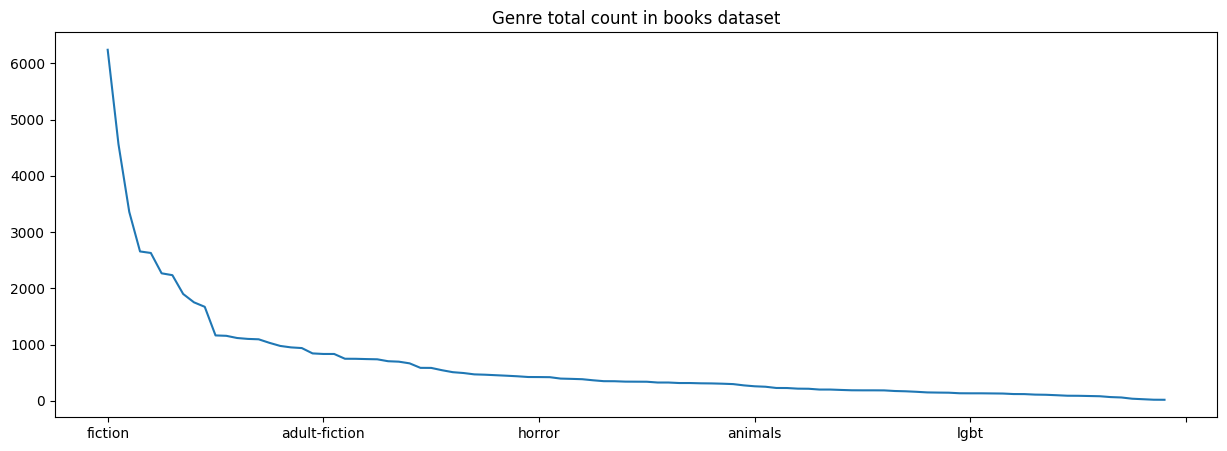

In [12]:

#pd.Series is one dimensional labeled array and takes in any value such as an integer, string, floats 
# Here, the genres value - which are unique genre from the dataset is being passed into the Series and is being counted
genres_counts = pd.Series(genres).value_counts()
print(genres_counts)

#plot is used for visualizing the data from series
genres_counts.plot(figsize=(15,5), title='Genre total count in books dataset')
plt.show()

In [13]:
# popular_genres = [k for k, v in genres_counts.items() if v >= 1000]
# print(f'{len(popular_genres)} genres have over 2000 counts in dataset.\n\nThey are:\n\n{popular_genres}')

* Creating a new column called 'genre_count' and assigning the value of the lengths
* Getting the dataFrame whose genre count is greater than 0
* Dropping the genre count column

In [14]:
popular_genres = ['fiction', 'classics', 'historical', 'fantasy', 'adventure']

df.genres = df.genres.apply(lambda genres:[g for g in genres if g in popular_genres])
df['genre_count'] = df.genres.apply(len)

df = df[df.genre_count > 0]
df.drop('genre_count', axis=1, inplace=True)


In [15]:
genres = [g for r in df.genres for g in r]
genres_counts = pd.Series(genres).value_counts()
print(genres_counts)

fiction       6244
classics      4565
historical    3360
fantasy       1162
adventure     1100
Name: count, dtype: int64


# Extract Stories and Genres

In [16]:
# The plan is to make it more effective than this code. 
# Just for feasibility study -- removing other genres values 

df['genres'] = df['genres'].apply(lambda x: x[0])

df = df.drop(['lang', 'index'], axis=1)

df.head()


,title,text,genres
0,apocolocyntosis,"Produced by Ted Garvin, Ben Courtney and PG Di...",classics
1,the house on the borderland,"Produced by Suzanne Shell, Sjaani and PG Distr...",classics
2,the warriors,"Produced by Charles Aldarondo, Charlie Kirschn...",classics
4,la fiammetta,"Produced by Ted Garvin, Dave Morgan and PG Dis...",classics
5,carmilla,"Produced by Suzanne Shell, Sjaani and PG Distr...",classics


In [ ]:
# saving the file
df.to_csv('bookData.csv', index=False)